In [1]:
import pandas as pd
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
import itertools
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, ADASYN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
Zona_Comuna = pd.read_csv('Zona_Comuna.csv', delimiter=';')
#Se aprovechan de corregir valores que Area y perimetro a numerico, que venian con decimales, pero separados por comas en vez de puntos.
#tambien aparecio por ahi algun dato negativo, lo cual no tiene sentido para areas y perimetros. se corrige.
Zona_Comuna['AREA'] = pd.to_numeric(Zona_Comuna['AREA'].str.replace(',', '.'), errors='coerce').abs()
Zona_Comuna['PERIMETER'] = pd.to_numeric(Zona_Comuna['PERIMETER'].str.replace(',', '.'), errors='coerce').abs()
Zona_Comuna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         866 non-null    int64  
 1   AREA       866 non-null    float64
 2   Zona       866 non-null    int64  
 3   Com        866 non-null    int64  
 4   Comuna     866 non-null    object 
 5   PERIMETER  866 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 40.7+ KB


In [4]:
Usos_Zona = pd.read_csv('Usos_Zona.csv', delimiter=';')
Usos_Zona.fillna(0, inplace=True)
Usos_Zona['Distancia al centro (Km)'] = pd.to_numeric(Usos_Zona['Distancia al centro (Km)'].str.replace(',', '.'), errors='coerce')
Usos_Zona['m2_Comercio'] = pd.to_numeric(Usos_Zona['m2_Comercio'].str.replace(',', '.'), errors='coerce')
Usos_Zona['m2_Industrial'] = pd.to_numeric(Usos_Zona['m2_Industrial'].str.replace(',', '.'), errors='coerce')
Usos_Zona['m2_Servicios'] = pd.to_numeric(Usos_Zona['m2_Servicios'].str.replace(',', '.'), errors='coerce')
Usos_Zona['m2_Otros'] = pd.to_numeric(Usos_Zona['m2_Otros'].str.replace(',', '.'), errors='coerce')
Usos_Zona['Valor de oferta de vivienda (uf/m2) '] = pd.to_numeric(Usos_Zona['Valor de oferta de vivienda (uf/m2) '].str.replace(',', '.'), errors='coerce')
Usos_Zona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    740 non-null    int64  
 1   Zona_EOD                              740 non-null    int64  
 2   LETRA                                 740 non-null    object 
 3   Distancia al centro (Km)              740 non-null    float64
 4   m2_Comercio                           727 non-null    float64
 5   m2_Educacion                          740 non-null    float64
 6   m2_Residencial                        740 non-null    float64
 7   m2_Industrial                         727 non-null    float64
 8   m2_Servicios                          727 non-null    float64
 9   m2_Otros                              727 non-null    float64
 10  GSE Alto                              740 non-null    float64
 11  GSE Medio Alto     

In [5]:
suma_total = Usos_Zona.sum(numeric_only=True)
reporte = pd.DataFrame(suma_total).reset_index()
reporte.columns = ['Columna', 'Suma Total']
reporte['Suma Total'] = reporte['Suma Total'].apply(lambda x: f"{x:,.2f}")
reporte

,Columna,Suma Total
0,id,"274,170.00"
1,Zona_EOD,"260,400.00"
2,Distancia al centro (Km),"8,714.34"
3,m2_Comercio,"13,425,214.00"
4,m2_Educacion,"7,609,663.00"
5,m2_Residencial,"139,384,873.00"
6,m2_Industrial,"25,202,232.00"
7,m2_Servicios,"16,325,785.00"
8,m2_Otros,"14,238,213.00"
9,GSE Alto,"184,906.00"


In [6]:
#Aquí uniremos la información correspondiente de a que comuna corresponde cada zona, agregando además el area (superficie de la zona) en m2
#Cabe resaltar que existen más zonas eod en el area metropolitana (866 zonas) de las que teniamos con asignacion de datos SII de m2 por usos (740 zonas)
#No es relevante al caso, ya que son zonas perifericas a lo urbano donde no se cuenta con info SII certera
#Lo importante es verificar que no queden zonas con datos m2 por usos sin asignación de comuna
Usos_Final = pd.merge(Usos_Zona, Zona_Comuna, left_on='Zona_EOD', right_on='Zona', how='left')
Usos_Final

,id,Zona_EOD,LETRA,Distancia al centro (Km),m2_Comercio,m2_Educacion,m2_Residencial,m2_Industrial,m2_Servicios,m2_Otros,...,GSE Bajo,Ed. Básica y Media,Ed. Superior,Valor de oferta de vivienda (uf/m2),ID,AREA,Zona,Com,Comuna,PERIMETER
0,1,1,0,4.78,12744.0,6333.0,78074.0,61992.0,10964.0,13686.0,...,483.0,1492.0,0.0,NaN,1,3.322938e+05,1,13101,Santiago,2387.304832
1,2,2,0,3.95,38325.0,37454.0,317556.0,48208.0,30940.0,20744.0,...,425.0,4316.0,3431.0,34.79,2,3.210641e+05,2,13101,Santiago,2269.318125
2,3,3,0,3.90,46434.0,8041.0,220002.0,97680.0,15723.0,11143.0,...,1452.0,1594.0,0.0,32.26,3,3.306885e+05,3,13101,Santiago,2301.318272
3,4,4,0,2.90,31768.0,10895.0,245378.0,51248.0,19715.0,24626.0,...,139.0,1520.0,0.0,37.92,4,3.174328e+05,4,13101,Santiago,2256.239626
4,5,5,0,4.15,11326.0,4685.0,59895.0,67859.0,6731.0,19666.0,...,15.0,0.0,0.0,NaN,5,3.101944e+05,5,13101,Santiago,2238.872264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,736,692,0,52.42,2670.0,4087.0,95963.0,2173.0,3528.0,663.0,...,0.0,1705.0,0.0,NaN,692,3.258026e+05,692,13201,Puente Alto,2558.369697
736,737,693,0,92.26,1516.0,5224.0,31346.0,428.0,4569.0,799.0,...,0.0,1211.0,0.0,NaN,693,7.520971e+05,693,13201,Puente Alto,3695.621379
737,738,694,0,76.80,521.0,1309.0,40831.0,356.0,2018.0,0.0,...,0.0,967.0,0.0,NaN,694,2.218971e+07,694,13201,Puente Alto,24603.534290
738,739,695,0,17.08,NaN,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,695,4.464453e+06,695,13201,Puente Alto,8415.330798


In [7]:
#Aquí revisaremos si existen Zonas_EOD con datos de m2 que hayan quedado sin comuna asignada
#El resultado muestra un dataset vacio, por lo que podemos asumir que todas las zonas eod con datos de m2 construidos (740 zonas) tienen una comuna asignada.
comuna_nan = Usos_Final[Usos_Final['Comuna'].isna()]
comuna_nan

,id,Zona_EOD,LETRA,Distancia al centro (Km),m2_Comercio,m2_Educacion,m2_Residencial,m2_Industrial,m2_Servicios,m2_Otros,...,GSE Bajo,Ed. Básica y Media,Ed. Superior,Valor de oferta de vivienda (uf/m2),ID,AREA,Zona,Com,Comuna,PERIMETER


In [8]:
Usos_Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 0 to 739
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    740 non-null    int64  
 1   Zona_EOD                              740 non-null    int64  
 2   LETRA                                 740 non-null    object 
 3   Distancia al centro (Km)              740 non-null    float64
 4   m2_Comercio                           727 non-null    float64
 5   m2_Educacion                          740 non-null    float64
 6   m2_Residencial                        740 non-null    float64
 7   m2_Industrial                         727 non-null    float64
 8   m2_Servicios                          727 non-null    float64
 9   m2_Otros                              727 non-null    float64
 10  GSE Alto                              740 non-null    float64
 11  GSE Medio Alto     

In [9]:
#Falta hacer la ultima corrección al dataset, y es que en algunos casos tenemos Zona y Letra (ej: 114A y 114B) por lo cual agruparemos los datos en funcion del codigo de la zona.
#Para una correcta agregación los atributos m2 por usos se suman, al igual que GSE y matriculas. La informacion que se pego via merge se mantiene el primero (ya que se repite)
#Se aprovecha de eliminar campos 'id', 'LETRA', 'Distancia al centro', y de la información que venia via el merge se eliminan 'ID', 'Zona', 'Com'

agregacion = {
    'id': 'first',
    'LETRA': 'first',
    'Distancia al centro (Km)': 'first',
    'm2_Comercio': 'sum',
    'm2_Educacion': 'sum',
    'm2_Residencial': 'sum',
    'm2_Industrial': 'sum',
    'm2_Servicios': 'sum',
    'm2_Otros': 'sum',
    'GSE Alto': 'sum',
    'GSE Medio Alto': 'sum',
    'GSE Medio': 'sum',
    'GSE Medio bajo': 'sum',
    'GSE Bajo': 'sum',
    'Ed. Básica y Media': 'sum',
    'Ed. Superior': 'sum',
    'Valor de oferta de vivienda (uf/m2) ': 'first',
    'ID': 'first',
    'AREA': 'first',
    'Zona': 'first',
    'Com': 'first',
    'Comuna': 'first',
    'PERIMETER': 'first'
}

Usos_Final_agrupado = Usos_Final.groupby('Zona_EOD').agg(agregacion).reset_index()
Usos_Final_agrupado = Usos_Final_agrupado.drop(['id', 'LETRA', 'Distancia al centro (Km)', 'ID', 'Zona', 'Com'], axis=1)
Usos_Final = Usos_Final_agrupado
Usos_Final

,Zona_EOD,m2_Comercio,m2_Educacion,m2_Residencial,m2_Industrial,m2_Servicios,m2_Otros,GSE Alto,GSE Medio Alto,GSE Medio,GSE Medio bajo,GSE Bajo,Ed. Básica y Media,Ed. Superior,Valor de oferta de vivienda (uf/m2),AREA,Comuna,PERIMETER
0,1,12744.0,6333.0,78074.0,61992.0,10964.0,13686.0,0.0,28.0,787.0,282.0,483.0,1492.0,0.0,NaN,3.322938e+05,Santiago,2387.304832
1,2,38325.0,37454.0,317556.0,48208.0,30940.0,20744.0,0.0,715.0,1422.0,2111.0,425.0,4316.0,3431.0,34.79,3.210641e+05,Santiago,2269.318125
2,3,46434.0,8041.0,220002.0,97680.0,15723.0,11143.0,0.0,379.0,625.0,612.0,1452.0,1594.0,0.0,32.26,3.306885e+05,Santiago,2301.318272
3,4,31768.0,10895.0,245378.0,51248.0,19715.0,24626.0,221.0,1272.0,450.0,323.0,139.0,1520.0,0.0,37.92,3.174328e+05,Santiago,2256.239626
4,5,11326.0,4685.0,59895.0,67859.0,6731.0,19666.0,0.0,87.0,664.0,72.0,15.0,0.0,0.0,NaN,3.101944e+05,Santiago,2238.872264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,692,2670.0,4087.0,95963.0,2173.0,3528.0,663.0,0.0,0.0,0.0,0.0,0.0,1705.0,0.0,NaN,3.258026e+05,Puente Alto,2558.369697
691,693,1516.0,5224.0,31346.0,428.0,4569.0,799.0,0.0,0.0,0.0,0.0,0.0,1211.0,0.0,NaN,7.520971e+05,Puente Alto,3695.621379
692,694,521.0,1309.0,40831.0,356.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,0.0,NaN,2.218971e+07,Puente Alto,24603.534290
693,695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.464453e+06,Puente Alto,8415.330798


In [10]:
Usos_Final.describe(), Usos_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Zona_EOD                              695 non-null    int64  
 1   m2_Comercio                           695 non-null    float64
 2   m2_Educacion                          695 non-null    float64
 3   m2_Residencial                        695 non-null    float64
 4   m2_Industrial                         695 non-null    float64
 5   m2_Servicios                          695 non-null    float64
 6   m2_Otros                              695 non-null    float64
 7   GSE Alto                              695 non-null    float64
 8   GSE Medio Alto                        695 non-null    float64
 9   GSE Medio                             695 non-null    float64
 10  GSE Medio bajo                        695 non-null    float64
 11  GSE Bajo           

(        Zona_EOD    m2_Comercio   m2_Educacion  m2_Residencial  m2_Industrial  \
 count  695.00000     695.000000     695.000000    6.950000e+02   6.950000e+02   
 mean   348.18705   19316.854676   10949.155396    2.005538e+05   3.626220e+04   
 std    201.03728   34266.739482   16507.578326    1.996264e+05   1.034620e+05   
 min      1.00000       0.000000       0.000000    0.000000e+00   0.000000e+00   
 25%    174.50000    2863.000000    1954.500000    8.082850e+04   1.352000e+03   
 50%    348.00000    7812.000000    6333.000000    1.465840e+05   7.784000e+03   
 75%    521.50000   19654.500000   13990.500000    2.453450e+05   3.526250e+04   
 max    696.00000  514215.000000  199108.000000    1.431888e+06   1.923104e+06   
 
         m2_Servicios       m2_Otros     GSE Alto  GSE Medio Alto  \
 count     695.000000     695.000000   695.000000      695.000000   
 mean    23490.338129   20486.637410   266.051799      513.463309   
 std     63046.548994   56012.959198   723.151913    

In [11]:
Usos_Final

,Zona_EOD,m2_Comercio,m2_Educacion,m2_Residencial,m2_Industrial,m2_Servicios,m2_Otros,GSE Alto,GSE Medio Alto,GSE Medio,GSE Medio bajo,GSE Bajo,Ed. Básica y Media,Ed. Superior,Valor de oferta de vivienda (uf/m2),AREA,Comuna,PERIMETER
0,1,12744.0,6333.0,78074.0,61992.0,10964.0,13686.0,0.0,28.0,787.0,282.0,483.0,1492.0,0.0,NaN,3.322938e+05,Santiago,2387.304832
1,2,38325.0,37454.0,317556.0,48208.0,30940.0,20744.0,0.0,715.0,1422.0,2111.0,425.0,4316.0,3431.0,34.79,3.210641e+05,Santiago,2269.318125
2,3,46434.0,8041.0,220002.0,97680.0,15723.0,11143.0,0.0,379.0,625.0,612.0,1452.0,1594.0,0.0,32.26,3.306885e+05,Santiago,2301.318272
3,4,31768.0,10895.0,245378.0,51248.0,19715.0,24626.0,221.0,1272.0,450.0,323.0,139.0,1520.0,0.0,37.92,3.174328e+05,Santiago,2256.239626
4,5,11326.0,4685.0,59895.0,67859.0,6731.0,19666.0,0.0,87.0,664.0,72.0,15.0,0.0,0.0,NaN,3.101944e+05,Santiago,2238.872264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,692,2670.0,4087.0,95963.0,2173.0,3528.0,663.0,0.0,0.0,0.0,0.0,0.0,1705.0,0.0,NaN,3.258026e+05,Puente Alto,2558.369697
691,693,1516.0,5224.0,31346.0,428.0,4569.0,799.0,0.0,0.0,0.0,0.0,0.0,1211.0,0.0,NaN,7.520971e+05,Puente Alto,3695.621379
692,694,521.0,1309.0,40831.0,356.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,0.0,NaN,2.218971e+07,Puente Alto,24603.534290
693,695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.464453e+06,Puente Alto,8415.330798


# Gráfico

<Figure size 1200x1000 with 0 Axes>

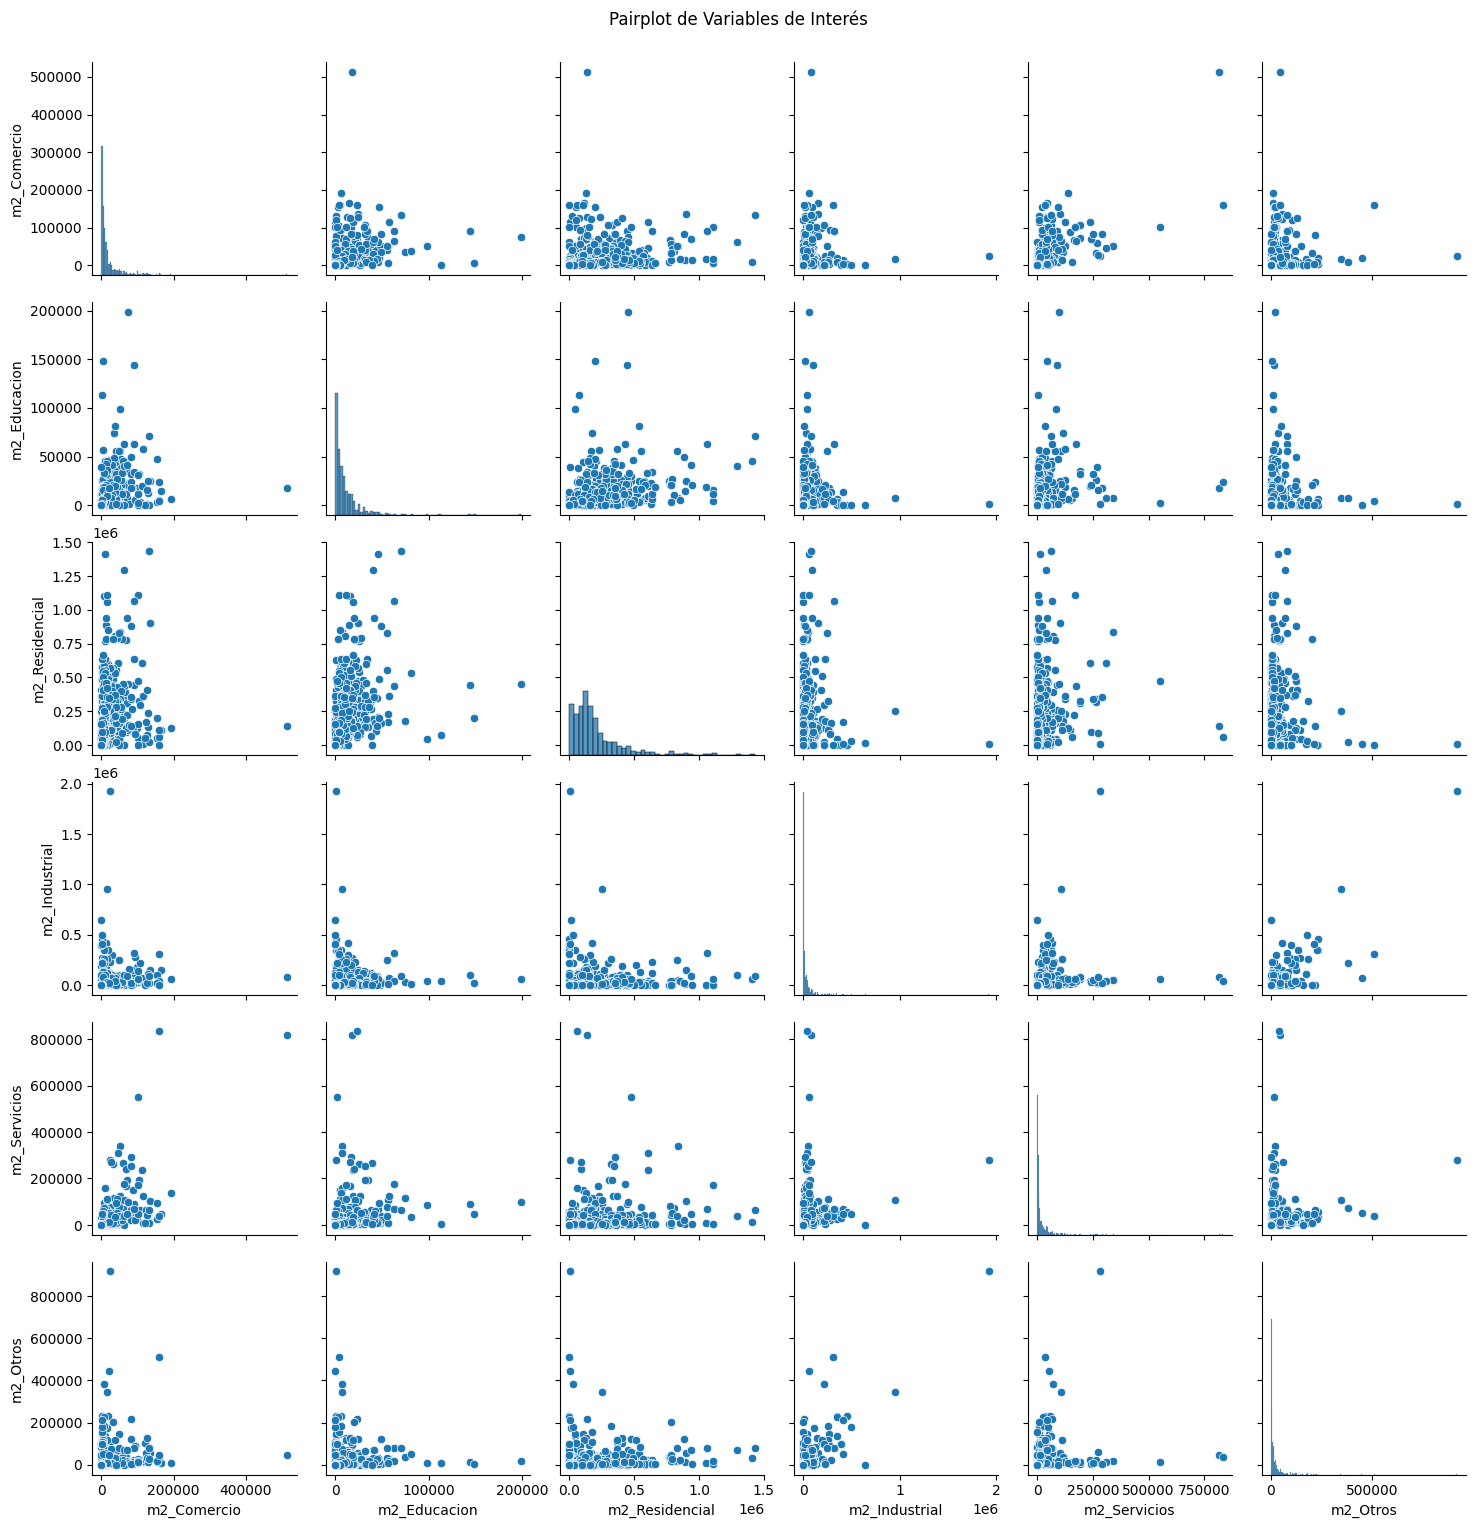

In [12]:
variables_de_interes = ['m2_Comercio','m2_Educacion', 'm2_Residencial', 'm2_Industrial', 'm2_Servicios', 'm2_Otros']
g = Usos_Final[variables_de_interes]

plt.figure(figsize=(12, 10))
sns.pairplot(g)
plt.suptitle('Pairplot de Variables de Interés', y=1.02)
plt.show()


In [210]:
correlacion = Usos_Final[variables_de_interes].corr()
print(correlacion)


                m2_Comercio  m2_Educacion  m2_Residencial  m2_Industrial  \
m2_Comercio        1.000000      0.277965        0.200581       0.130108   
m2_Educacion       0.277965      1.000000        0.364318       0.035978   
m2_Residencial     0.200581      0.364318        1.000000      -0.001230   
m2_Industrial      0.130108      0.035978       -0.001230       1.000000   
m2_Servicios       0.634742      0.213032        0.140121       0.230137   
m2_Otros           0.155315      0.019343        0.035634       0.749404   

                m2_Servicios  m2_Otros  
m2_Comercio         0.634742  0.155315  
m2_Educacion        0.213032  0.019343  
m2_Residencial      0.140121  0.035634  
m2_Industrial       0.230137  0.749404  
m2_Servicios        1.000000  0.194358  
m2_Otros            0.194358  1.000000  


In [13]:
variables_dependientes = ['m2_Comercio', 'm2_Educacion', 'm2_Residencial', 'm2_Industrial', 'm2_Servicios', 'm2_Otros']
resultados = []

for variable_dependiente in variables_dependientes:
    lista_restantes = [var for var in variables_dependientes if var != variable_dependiente]

    for r in range(1, len(lista_restantes) + 1):
        for comb in itertools.combinations(lista_restantes, r):
            X = Usos_Final[list(comb)]
            y = Usos_Final[variable_dependiente]
            X = sm.add_constant(X)  

            model = sm.OLS(y, X).fit()
            resultados.append({
                'Variable Dependiente': variable_dependiente,
                'Variables Independientes': ', '.join(comb),
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj,
                'F-statistic': model.fvalue,
                'P-value': model.f_pvalue
            })
resultados_rl = pd.DataFrame(resultados)
print(resultados_rl)
mejores_modelos_rl = resultados_rl.sort_values(by='Adjusted R-squared', ascending=False)
print(mejores_modelos_rl)


    Variable Dependiente                           Variables Independientes  \
0            m2_Comercio                                       m2_Educacion   
1            m2_Comercio                                     m2_Residencial   
2            m2_Comercio                                      m2_Industrial   
3            m2_Comercio                                       m2_Servicios   
4            m2_Comercio                                           m2_Otros   
..                   ...                                                ...   
181             m2_Otros  m2_Comercio, m2_Educacion, m2_Residencial, m2_...   
182             m2_Otros  m2_Comercio, m2_Educacion, m2_Industrial, m2_S...   
183             m2_Otros  m2_Comercio, m2_Residencial, m2_Industrial, m2...   
184             m2_Otros  m2_Educacion, m2_Residencial, m2_Industrial, m...   
185             m2_Otros  m2_Comercio, m2_Educacion, m2_Residencial, m2_...   

     R-squared  Adjusted R-squared  F-statistic    

In [14]:
mejores_modelos_rl.head(5)

,Variable Dependiente,Variables Independientes,R-squared,Adjusted R-squared,F-statistic,P-value
123,m2_Industrial,"m2_Comercio, m2_Educacion, m2_Residencial, m2_...",0.573351,0.570255,185.182414,7.634369e-125
121,m2_Industrial,"m2_Comercio, m2_Residencial, m2_Servicios, m2_...",0.572710,0.570233,231.207377,7.891863e-126
113,m2_Industrial,"m2_Comercio, m2_Servicios, m2_Otros",0.571625,0.569765,307.357229,9.919675e-127
120,m2_Industrial,"m2_Comercio, m2_Educacion, m2_Servicios, m2_Otros",0.571797,0.569315,230.346261,1.645982e-125
117,m2_Industrial,"m2_Residencial, m2_Servicios, m2_Otros",0.570627,0.568763,306.107496,2.214512e-126


In [15]:
mejores_modelos_rl.tail(5)

,Variable Dependiente,Variables Independientes,R-squared,Adjusted R-squared,F-statistic,P-value
102,m2_Industrial,"m2_Educacion, m2_Residencial",0.001531,-0.001354,0.530673,0.588448
95,m2_Industrial,m2_Residencial,0.000002,-0.001441,0.001048,0.974186
64,m2_Residencial,m2_Industrial,0.000002,-0.001441,0.001048,0.974186
44,m2_Educacion,"m2_Industrial, m2_Otros",0.001427,-0.001459,0.494377,0.610166
164,m2_Otros,"m2_Educacion, m2_Residencial",0.001316,-0.001570,0.456089,0.633948


## random forest

# RF FINAL FINAL

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
variables = ['m2_Comercio', 'm2_Educacion', 'm2_Residencial', 'm2_Industrial', 'm2_Servicios', 'm2_Otros']
resultados_finales = []
scaler = StandardScaler()

def ajustar_modelo_rf(uso_objetivo, variables):
    X = Usos_Final[list(variables)]
    y = Usos_Final[uso_objetivo]
    X_normalized = scaler.fit_transform(X)

    modelo_rf = RandomForestRegressor(random_state=123)
    modelo_rf.fit(X_normalized, y)
    y_pred = modelo_rf.predict(X_normalized)

    r_2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)

    return r_2, mse, rmse, modelo_rf.feature_importances_

resultados_rf_finales = []

for variable_dependiente in variables:
    lista_restantes = [var for var in variables if var != variable_dependiente]
    mejor_r2 = -float('inf')
    mejor_comb = None
    mejor_importancias = None
    mejor_mse = float('inf')
    mejor_rmse = float('inf')

    for r in range(1, len(lista_restantes) + 1):
        for comb in itertools.combinations(lista_restantes, r):
            r_2, mse, rmse, importancias = ajustar_modelo_rf(variable_dependiente, comb)

            if r_2 > mejor_r2:
                mejor_r2 = r_2
                mejor_comb = comb
                mejor_importancias = importancias
                mejor_mse = mse
                mejor_rmse = rmse

    resultados_rf_finales.append({
        'Variable Dependiente': variable_dependiente,
        'Mejor Combinación': ', '.join(mejor_comb) if mejor_comb else None,
        'Mejor R^2': mejor_r2,
        'MSE': mejor_mse,
        'RMSE': mejor_rmse,
        'Importancia': mejor_importancias
    })

resultados_rf_final = pd.DataFrame(resultados_rf_finales)

for index, row in resultados_rf_final.iterrows():
    print(f"Variable Dependiente: {row['Variable Dependiente']}")
    print(f"Mejor Combinación: {row['Mejor Combinación']}")
    print(f"Mejor R^2: {row['Mejor R^2']:.4f}")
    print(f"MSE: {row['MSE']:.4f}")
    print(f"RMSE: {row['RMSE']:.4f}")
    print("Importancia de Variables:")
    if row['Importancia'] is not None:
        importancias_df = pd.DataFrame({
            'Variable': row['Mejor Combinación'].split(', '),
            'Importancia': row['Importancia']
        })
        print(importancias_df.sort_values(by='Importancia', ascending=False))
    print("\n")

print(resultados_rf_final)


Variable Dependiente: m2_Comercio
Mejor Combinación: m2_Residencial, m2_Industrial, m2_Servicios, m2_Otros
Mejor R^2: 0.9138
MSE: 101015622.4351
RMSE: 10050.6528
Importancia de Variables:
         Variable  Importancia
2    m2_Servicios     0.636930
3        m2_Otros     0.134012
1   m2_Industrial     0.116614
0  m2_Residencial     0.112444


Variable Dependiente: m2_Educacion
Mejor Combinación: m2_Residencial, m2_Servicios
Mejor R^2: 0.9038
MSE: 26176861.7131
RMSE: 5116.3328
Importancia de Variables:
         Variable  Importancia
0  m2_Residencial      0.50193
1    m2_Servicios      0.49807


Variable Dependiente: m2_Residencial
Mejor Combinación: m2_Comercio, m2_Educacion, m2_Industrial, m2_Servicios, m2_Otros
Mejor R^2: 0.9031
MSE: 3855650135.7332
RMSE: 62093.8816
Importancia de Variables:
        Variable  Importancia
1   m2_Educacion     0.382652
4       m2_Otros     0.216545
2  m2_Industrial     0.171449
3   m2_Servicios     0.118614
0    m2_Comercio     0.110740


Variable Depe

In [18]:
resultados_rf_final

,Variable Dependiente,Mejor Combinación,Mejor R^2,MSE,RMSE,Importancia
0,m2_Comercio,"m2_Residencial, m2_Industrial, m2_Servicios, m...",0.913847,1.010156e+08,10050.652836,"[0.11244386334854312, 0.1166136027434987, 0.63..."
1,m2_Educacion,"m2_Residencial, m2_Servicios",0.903800,2.617686e+07,5116.332838,"[0.501930180703414, 0.49806981929658606]"
2,m2_Residencial,"m2_Comercio, m2_Educacion, m2_Industrial, m2_S...",0.903108,3.855650e+09,62093.881629,"[0.11073955549396865, 0.38265225250654655, 0.1..."
3,m2_Industrial,"m2_Educacion, m2_Servicios, m2_Otros",0.923107,8.219116e+08,28669.000663,"[0.090738310079863, 0.24853756269147317, 0.660..."
4,m2_Servicios,"m2_Comercio, m2_Educacion, m2_Residencial, m2_...",0.901536,3.908192e+08,19769.148518,"[0.5794802723416884, 0.12497103650551392, 0.10..."
5,m2_Otros,"m2_Comercio, m2_Educacion, m2_Residencial, m2_...",0.912045,2.755584e+08,16599.951550,"[0.1291182184766744, 0.050198665360503894, 0.1..."


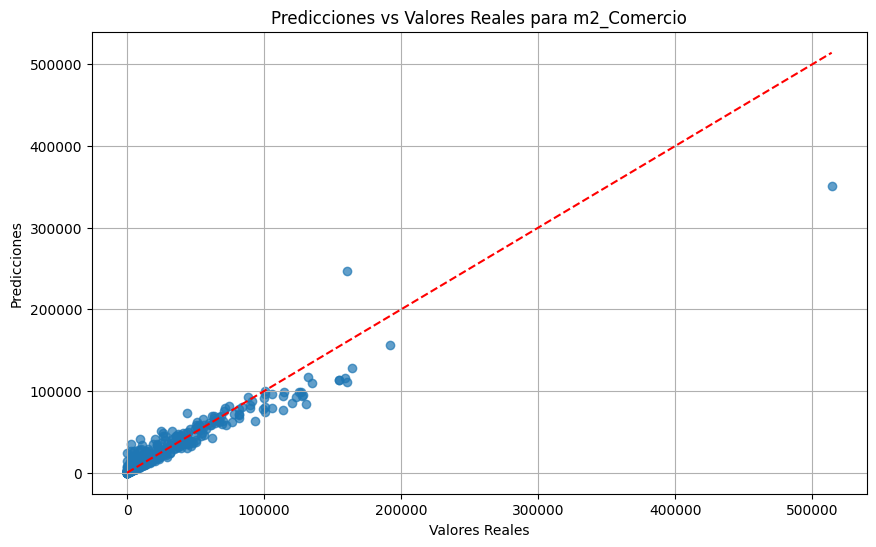

In [214]:
variable_dependiente = 'm2_Comercio'
lista = [var for var in variables_dependientes if var != variable_dependiente]
X = Usos_Final[lista]  
y = Usos_Final[variable_dependiente] 

model_rf = RandomForestRegressor()
model_rf.fit(X, y)
y_pred = model_rf.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales para ' + variable_dependiente)
plt.grid(True)
plt.show()


## Decision Tree Regressor

In [ ]:
import pandas as pd
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


In [20]:
from sklearn.tree import DecisionTreeRegressor
variables_dependientes = ['m2_Comercio', 'm2_Educacion', 'm2_Residencial', 'm2_Industrial', 'm2_Servicios', 'm2_Otros']
resultados_finales = []
scaler = StandardScaler()

def ajustar_modelo_tree(uso_objetivo, variables):
    X = Usos_Final[list(variables)]
    y = Usos_Final[uso_objetivo]
    X_normalized = scaler.fit_transform(X)
    
    modelo_tree = DecisionTreeRegressor(max_depth=5, min_samples_split=10)
    modelo_tree.fit(X_normalized, y)
    
    y_pred = modelo_tree.predict(X_normalized)
    r_2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    
    return r_2, mse, rmse, modelo_tree.feature_importances_

for variable_dependiente in variables_dependientes:
    lista_restantes = [var for var in variables_dependientes if var != variable_dependiente]
    mejor_r2 = -float('inf')
    mejor_comb = None
    mejor_importancias = None
    mejor_mse = float('inf')
    mejor_rmse = float('inf')

    for r in range(1, len(lista_restantes) + 1):
        for comb in itertools.combinations(lista_restantes, r):
            r_2, mse, rmse, importancias = ajustar_modelo_tree(variable_dependiente, comb)

            if r_2 > mejor_r2:
                mejor_r2 = r_2
                mejor_comb = comb
                mejor_importancias = importancias
                mejor_mse = mse
                mejor_rmse = rmse

    resultados_finales.append({
        'Variable Dependiente': variable_dependiente,
        'Mejor Combinación': ', '.join(mejor_comb) if mejor_comb else None,
        'Mejor R^2': mejor_r2,
        'MSE': mejor_mse,
        'RMSE': mejor_rmse,
        'Importancias': mejor_importancias
    })

resultados_tree_final = pd.DataFrame(resultados_finales)

for index, row in resultados_tree_final.iterrows():
    print(f"Variable Dependiente: {row['Variable Dependiente']}")
    print(f"Mejor Combinación: {row['Mejor Combinación']}")
    print(f"Mejor R^2: {row['Mejor R^2']:.4f}")
    print(f"MSE: {row['MSE']:.4f}")
    print(f"RMSE: {row['RMSE']:.4f}")
    print("Importancias de Variables:")
    if row['Importancias'] is not None:
        importancias_df = pd.DataFrame({
            'Variable': row['Mejor Combinación'].split(', '),
            'Importancia': row['Importancias']
        })
        print(importancias_df.sort_values(by='Importancia', ascending=False))
    print("\n")

print(resultados_tree_final)


Variable Dependiente: m2_Comercio
Mejor Combinación: m2_Educacion, m2_Servicios, m2_Otros
Mejor R^2: 0.6315
MSE: 432070554.5723
RMSE: 20786.3069
Importancias de Variables:
       Variable  Importancia
1  m2_Servicios     0.872119
0  m2_Educacion     0.101419
2      m2_Otros     0.026462


Variable Dependiente: m2_Educacion
Mejor Combinación: m2_Comercio, m2_Residencial, m2_Industrial
Mejor R^2: 0.6629
MSE: 91734152.0933
RMSE: 9577.7947
Importancias de Variables:
         Variable  Importancia
1  m2_Residencial     0.428750
0     m2_Comercio     0.330455
2   m2_Industrial     0.240795


Variable Dependiente: m2_Residencial
Mejor Combinación: m2_Educacion, m2_Industrial, m2_Servicios, m2_Otros
Mejor R^2: 0.5164
MSE: 19243696813.3847
RMSE: 138721.6523
Importancias de Variables:
        Variable  Importancia
0   m2_Educacion     0.555621
3       m2_Otros     0.249943
1  m2_Industrial     0.103330
2   m2_Servicios     0.091107


Variable Dependiente: m2_Industrial
Mejor Combinación: m2_Come

In [21]:
resultados_tree_final

,Variable Dependiente,Mejor Combinación,Mejor R^2,MSE,RMSE,Importancias
0,m2_Comercio,"m2_Educacion, m2_Servicios, m2_Otros",0.631503,4.320706e+08,20786.306901,"[0.1014188337661534, 0.8721190443958068, 0.026..."
1,m2_Educacion,"m2_Comercio, m2_Residencial, m2_Industrial",0.662876,9.173415e+07,9577.794741,"[0.33045515000233905, 0.4287497690923402, 0.24..."
2,m2_Residencial,"m2_Educacion, m2_Industrial, m2_Servicios, m2_...",0.516409,1.924370e+10,138721.652288,"[0.5556205971372246, 0.10332962688188552, 0.09..."
3,m2_Industrial,"m2_Comercio, m2_Educacion, m2_Servicios, m2_Otros",0.843853,1.669055e+09,40854.067347,"[0.005181829280274002, 0.10798227105774351, 0...."
4,m2_Servicios,"m2_Educacion, m2_Residencial, m2_Industrial, m...",0.662563,1.339336e+09,36596.942446,"[0.41761278202469043, 0.3485686777516697, 0.19..."
5,m2_Otros,"m2_Industrial, m2_Servicios",0.800099,6.262761e+08,25025.509079,"[0.941966650517644, 0.05803334948235605]"


In [190]:
Usos_Final

,Zona_EOD,m2_Comercio,m2_Educacion,m2_Residencial,m2_Industrial,m2_Servicios,m2_Otros,GSE Alto,GSE Medio Alto,GSE Medio,GSE Medio bajo,GSE Bajo,Ed. Básica y Media,Ed. Superior,Valor de oferta de vivienda (uf/m2),AREA,Comuna,PERIMETER
0,1,12744.0,6333.0,78074.0,61992.0,10964.0,13686.0,0.0,28.0,787.0,282.0,483.0,1492.0,0.0,NaN,3.322938e+05,Santiago,2387.304832
1,2,38325.0,37454.0,317556.0,48208.0,30940.0,20744.0,0.0,715.0,1422.0,2111.0,425.0,4316.0,3431.0,34.79,3.210641e+05,Santiago,2269.318125
2,3,46434.0,8041.0,220002.0,97680.0,15723.0,11143.0,0.0,379.0,625.0,612.0,1452.0,1594.0,0.0,32.26,3.306885e+05,Santiago,2301.318272
3,4,31768.0,10895.0,245378.0,51248.0,19715.0,24626.0,221.0,1272.0,450.0,323.0,139.0,1520.0,0.0,37.92,3.174328e+05,Santiago,2256.239626
4,5,11326.0,4685.0,59895.0,67859.0,6731.0,19666.0,0.0,87.0,664.0,72.0,15.0,0.0,0.0,NaN,3.101944e+05,Santiago,2238.872264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,692,2670.0,4087.0,95963.0,2173.0,3528.0,663.0,0.0,0.0,0.0,0.0,0.0,1705.0,0.0,NaN,3.258026e+05,Puente Alto,2558.369697
691,693,1516.0,5224.0,31346.0,428.0,4569.0,799.0,0.0,0.0,0.0,0.0,0.0,1211.0,0.0,NaN,7.520971e+05,Puente Alto,3695.621379
692,694,521.0,1309.0,40831.0,356.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,0.0,NaN,2.218971e+07,Puente Alto,24603.534290
693,695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.464453e+06,Puente Alto,8415.330798


In [217]:
Usos_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Zona_EOD                              695 non-null    int64  
 1   m2_Comercio                           695 non-null    float64
 2   m2_Educacion                          695 non-null    float64
 3   m2_Residencial                        695 non-null    float64
 4   m2_Industrial                         695 non-null    float64
 5   m2_Servicios                          695 non-null    float64
 6   m2_Otros                              695 non-null    float64
 7   GSE Alto                              695 non-null    float64
 8   GSE Medio Alto                        695 non-null    float64
 9   GSE Medio                             695 non-null    float64
 10  GSE Medio bajo                        695 non-null    float64
 11  GSE Bajo           

(        Zona_EOD    m2_Comercio   m2_Educacion  m2_Residencial  m2_Industrial  \
 count  695.00000     695.000000     695.000000    6.950000e+02   6.950000e+02   
 mean   348.18705   19316.854676   10949.155396    2.005538e+05   3.626220e+04   
 std    201.03728   34266.739482   16507.578326    1.996264e+05   1.034620e+05   
 min      1.00000       0.000000       0.000000    0.000000e+00   0.000000e+00   
 25%    174.50000    2863.000000    1954.500000    8.082850e+04   1.352000e+03   
 50%    348.00000    7812.000000    6333.000000    1.465840e+05   7.784000e+03   
 75%    521.50000   19654.500000   13990.500000    2.453450e+05   3.526250e+04   
 max    696.00000  514215.000000  199108.000000    1.431888e+06   1.923104e+06   
 
         m2_Servicios       m2_Otros     GSE Alto  GSE Medio Alto  \
 count     695.000000     695.000000   695.000000      695.000000   
 mean    23490.338129   20486.637410   266.051799      513.463309   
 std     63046.548994   56012.959198   723.151913    

In [ ]:
from sklearn.linear_model import LinearRegression

In [25]:
from sklearn.linear_model import LinearRegression
Usos_Final.columns = Usos_Final.columns.str.strip()
if 'Valor de oferta de vivienda (uf/m2)' in Usos_Final.columns:
    data_con_valores = Usos_Final[Usos_Final['Valor de oferta de vivienda (uf/m2)'].notnull()]
    data_sin_valores = Usos_Final[Usos_Final['Valor de oferta de vivienda (uf/m2)'].isnull()]

    X = data_con_valores[['m2_Comercio', 'm2_Educacion', 'm2_Residencial', 'm2_Industrial',
                           'm2_Servicios', 'm2_Otros', 'GSE Alto', 'GSE Medio Alto',
                           'GSE Medio', 'GSE Medio bajo', 'GSE Bajo']]
    y = data_con_valores['Valor de oferta de vivienda (uf/m2)']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  
    r_2 = r2_score(y_test, y_pred)

    print("Evaluación del modelo:")
    print(f"R^2: {r_2}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")  
    
    X_missing = data_sin_valores[['m2_Comercio', 'm2_Educacion', 'm2_Residencial', 'm2_Industrial',
                                       'm2_Servicios', 'm2_Otros', 'GSE Alto', 'GSE Medio Alto',
                                       'GSE Medio', 'GSE Medio bajo', 'GSE Bajo']]
    X_missing_scaled = scaler.transform(X_missing)
    valores_pred = modelo.predict(X_missing_scaled)
    Usos_Final.loc[Usos_Final['Valor de oferta de vivienda (uf/m2)'].isnull(), 'Valor de oferta de vivienda (uf/m2)'] = valores_pred
else:
    print("La columna 'Valor de oferta de vivienda (uf/m2)' no existe")


Evaluación del modelo:
R^2: 0.38082220106745956
MSE: 157.14480440510906
RMSE: 12.535741079214626


In [26]:
modelo_rf2 = RandomForestRegressor(n_estimators=100)
modelo_rf2.fit(X_train, y_train)
y_pred_rf = modelo_rf2.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r_2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

print("Evaluación random forest:")
print(f"R^2: {r_2_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")


Evaluación random forest:
R^2: 0.5852409458341171
MSE: 105.26415926816324
RMSE: 10.259832321639728


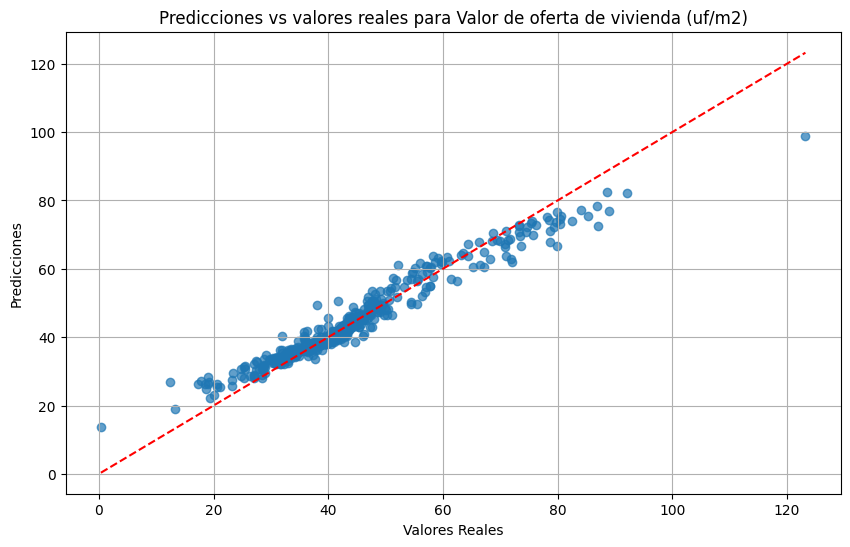

In [27]:
from sklearn.preprocessing import OneHotEncoder

variable_dependiente = 'Valor de oferta de vivienda (uf/m2)'
lista = [var for var in Usos_Final.columns if var != variable_dependiente]

X = Usos_Final[lista]
y = Usos_Final[variable_dependiente].dropna() 
X = X.loc[y.index]  
X_transformado = pd.get_dummies(X, drop_first=True)

modelo_rf2 = RandomForestRegressor()
modelo_rf2.fit(X_transformado, y)
y_pred = modelo_rf2.predict(X_transformado)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs valores reales para ' + variable_dependiente)
plt.grid(True)
plt.show()


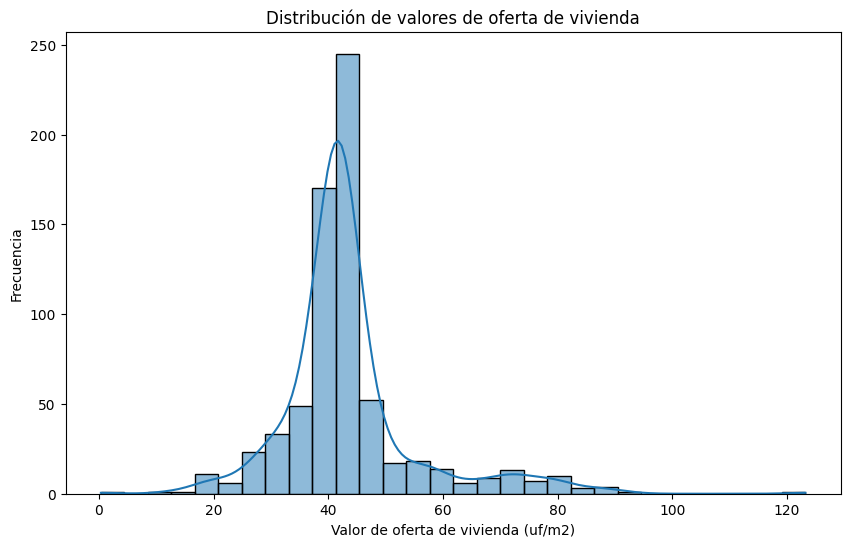

In [239]:
plt.figure(figsize=(10, 6))
sns.histplot(Usos_Final[variable_dependiente], bins=30, kde=True)
plt.title('Distribución de valores de oferta de vivienda')
plt.xlabel('Valor de oferta de vivienda (uf/m2)')
plt.ylabel('Frecuencia')
plt.show()


C:\Users\ccana\AppData\Local\Temp\ipykernel_12520\744068749.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = Usos_Final.corr()


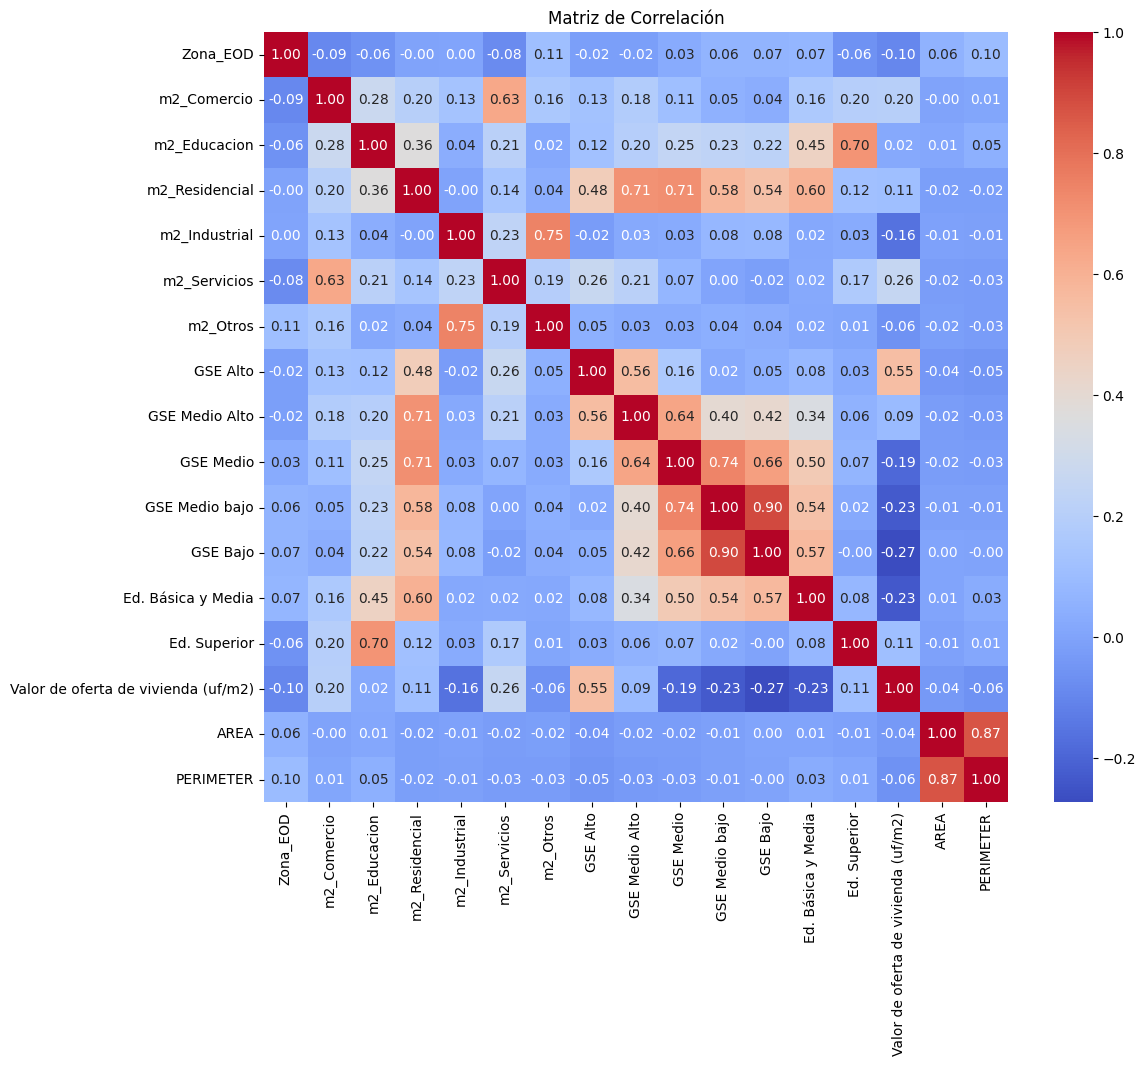

In [236]:
correlation_matrix = Usos_Final.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()
